In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
  #  for filename in filenames:
   #     print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-bqgod2ze
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-bqgod2ze
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 415.3 kB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=545e0c3e47d5cf13386914040782b8918bb7b88dd097cbc62bf97fbe420fe254
  Stored in directory: /tmp/pip-ephem-wheel-cache-gsxifv7n/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [3]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [4]:

from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as albu
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
#from keras.optimizers import Adam
import efficientnet.tfkeras as efn
#import efficientnet.keras as efn
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [5]:
bs= 16 # Increase Batch size based on your hardware capacity, if you have powerful GPU try BS=128,256...
train_path=r'../input/bird-species-classification-220-categories/Train'
test_path=r'../input/bird-species-classification-220-categories/Test'

In [6]:
train_gen=ImageDataGenerator(rescale=1./255, rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
Data_train=train_gen.flow_from_directory(train_path,target_size=(224,224),class_mode='categorical',batch_size=bs)

test_gen=ImageDataGenerator(rescale=1./255)
Data_test=test_gen.flow_from_directory(test_path,target_size=(224,224),class_mode='categorical',batch_size=bs)

Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [7]:
efnb0 = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224,224,3), classes= 200)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(200, activation='softmax'))

model.summary()

2022-07-19 21:50:34.777720: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 21:50:34.904287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 21:50:34.905155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 21:50:34.906591: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

258449408/258434480 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 200)               512200    
Total params: 64,609,880
Trainable params: 64,299,160
Non-trainable params: 310,720
_________________________________________________________________


In [8]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
model_history = model.fit_generator(Data_train, validation_data = Data_test, callbacks = [early_stop, rlrop],verbose = 1, epochs = 15)

#saving the trained model weights as data file in .h5 format
model.save_weights("birds_efficientnetb0_weights.h5")

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-07-19 21:50:53.201573: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-07-19 21:51:23.686232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


589/589 [==============================] - 430s 667ms/step - loss: 4.8505 - accuracy: 0.0632 - val_loss: 3.3982 - val_accuracy: 0.2944
Epoch 2/15
589/589 [==============================] - 383s 650ms/step - loss: 2.9462 - accuracy: 0.3214 - val_loss: 1.6664 - val_accuracy: 0.6133
Epoch 3/15
589/589 [==============================] - 382s 649ms/step - loss: 1.8503 - accuracy: 0.5441 - val_loss: 1.0908 - val_accuracy: 0.7216
Epoch 4/15
589/589 [==============================] - 383s 651ms/step - loss: 1.3636 - accuracy: 0.6490 - val_loss: 0.8662 - val_accuracy: 0.7523
Epoch 5/15
589/589 [==============================] - 383s 650ms/step - loss: 1.0724 - accuracy: 0.7211 - val_loss: 0.7394 - val_accuracy: 0.7877
Epoch 6/15
589/589 [==============================] - 381s 647ms/step - loss: 0.8828 - accuracy: 0.7625 - val_loss: 0.7067 - val_accuracy: 0.8024
Epoch 7/15
589/589 [==============================] - 383s 650ms/step - loss: 0.7198 - accuracy: 0.8054 - val_loss: 0.6985 - val_accura

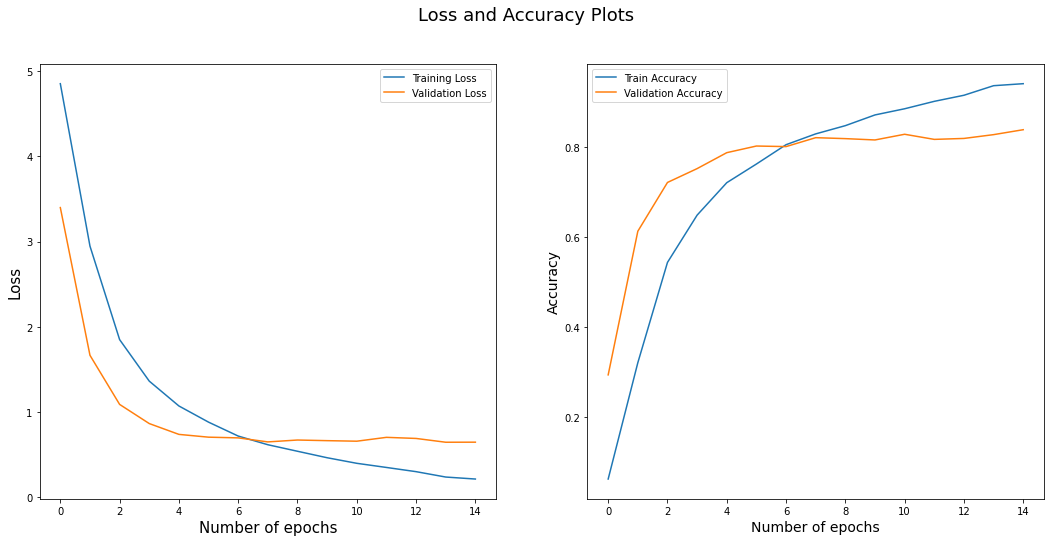

In [10]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()